Using TensorFlow backend.


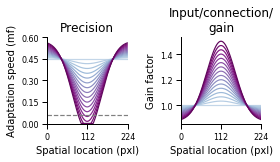

In [1]:
# Plot profiles for optimization
%matplotlib inline
import joblib
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import pandas as pd
import keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

from asn.attention.attend import attend_tf
from asn.attention.utils import normalize_precisionMap
from asn.attention.attn_param import set_attn_param

save = False
dir_path = os.path.abspath('')

cm = 1/2.54  # centimeters in inches
sns.set_context('paper', rc={'font.size': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8,
                          'figure.titleweight': 'bold', 'axes.labelsize':10, 'axes.titlesize':12})

output_path = dir_path + '/Figures/'

valid_loc = np.array([0.5, 0.5])
mf = 0.45
alphas= [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

valid_loc = np.array([valid_loc])
sess = tf.InteractiveSession()
K.set_session(sess)

AxWidth = np.array([40])

init = tf.global_variables_initializer()
init.run()

attn_param = set_attn_param(AxWidth1=AxWidth, AxWidth2=AxWidth, Precision=0)
R = attend_tf([1, 224, 224, 3], 'channels_last', attn_param, Ax1=valid_loc[:, 0], Ax2=valid_loc[:, 1])

Gain_mats = []
mf_mats = []
for alpha in alphas:
    Gain_mat = (1 + R * alpha)
    Gain_mats.append(Gain_mat.eval())

    mf_mat = mf - R * alpha
    mf_mat = normalize_precisionMap(mf_mat, mf, lowest_precision=0)
    mf_mats.append(mf_mat.eval())


Gain_mats = np.array(Gain_mats)
mf_mats = np.array(mf_mats)


colors = sns.color_palette("BuPu", len(alphas) + 4)


fig, ax = plt.subplots(1, 2, figsize=(10*cm,6*cm), sharex=True)
for a in range(len(alphas)):
    ax[1].plot(np.arange(224), Gain_mats[a, 0, :, 112, 0].T, c=colors[a + 4])
    ax[0].plot(np.arange(224), mf_mats[a, 0, :, 112, 0].T, c=colors[a + 4])
ax[0].set_ylabel('Adaptation speed (mf)')
ax[1].set_ylabel('Gain factor')
ax[0].set_title('Precision')
ax[1].set_title('Input/connection/\ngain')

ax[0].axhline(0.06, ls='--', color='gray')

ax[0].set_ylim([0, 0.6])
ax[0].set_yticks([0, 0.15, 0.3, 0.45, 0.6])

ax[0].set_xlabel('Spatial location (pxl)')
ax[1].set_xlabel('Spatial location (pxl)')
ax[1].set_xticks([0, 112, 224])
ax[1].set_xlim([0,224])


sns.despine()
plt.tight_layout()

if save == True:
    fig.savefig(output_path + 'OptimizationProfiles.pdf', dpi=300, transparent=True)
else:
    fig.show()


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


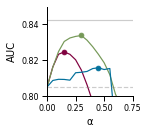

In [2]:
colors = sns.color_palette(sns.xkcd_palette(["wine", "moss", "ocean blue", "faded green", "dusty purple"]))
sns.set_palette(colors)

mechanisms = ['inputGain', 'outputGain', 'precision']

tracker = {}
for mechanism in mechanisms:
    tracker[mechanism] = joblib.load(dir_path + '/ModelEvaluation/Performance_' + mechanism + '.pkl')

df = pd.DataFrame()

for alpha in alphas:
    for mechanism in mechanisms:
        if mechanism == 'inputGain':
            cond = 'P-0_I-' + str(alpha) + '_O-0'
        elif mechanism == 'outputGain':
            cond = 'P-0_I-0_O-' + str(alpha)
        elif mechanism == 'precision':
            cond = 'P-' + str(alpha) + '_I-0_O-0'
        else:
            raise ValueError()

        if alpha == 0:
            df = df.append(pd.DataFrame({'Mechanism': [mechanism], 'Alpha': [alpha],
                                         'AUC': [tracker['inputGain']['attention_0.45'][cond]['valid']['AUC']]}),
                           ignore_index=True)

        else:
            df =df.append(pd.DataFrame({'Mechanism': [mechanism], 'Alpha': [alpha], 'AUC':[tracker[mechanism]['attention_0.45'][cond]['valid']['AUC']]}), ignore_index=True)


# Plot grid search results, Figure 3B
max_vals = [0.15, 0.3, 0.45]

fig, ax = plt.subplots(1, figsize=(5.5*cm,5*cm))
sns.lineplot(data=df, x='Alpha', y='AUC', hue='Mechanism', ax=ax, legend=False)
ax.axhline(tracker['inputGain']['mf_0.45']['AUC'], ls='--', c='gray', alpha = 0.4)
ax.axhline(tracker['inputGain']['analog_train']['AUC'],  c='gray', alpha = 0.4)

for m, mechanism in enumerate(['inputGain', 'outputGain', 'precision']):
    ax.scatter(max_vals[m], df.loc[(df['Mechanism'] == mechanism) & (df['Alpha'] == max_vals[m]), 'AUC'], c=colors[m])
ax.set_ylim([0.8, 0.85])
ax.set_yticks([0.8, 0.82, 0.84])
ax.set_xlim([0, 0.75])
ax.set_xticks([0, 0.25, 0.5, 0.75])
ax.set_ylabel('AUC')
ax.set_xlabel('α')
plt.tight_layout()
sns.despine()
if save == True:
    fig.savefig(output_path + 'MechanismsOptimization.pdf', dpi=300, transparent=True)
else:
    fig.show()